# New Thomas-Fermi Calculations

A new approach to calculate the electron density is presented using the integral of the Fermi function in energy from the bottom of the conduction band to $\infinity$.



In [ ]:
# ThomasFermi class for electron density calculations

import mpmath
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class ThomasFermi():
    '''
    Thomas-Fermi routines based on the polylog function approach.
    '''
    def __init__(self,physics):
        '''
        physics is a dict with the revelant physics
        
        x : linspace
        V_x : potential profile
        K_0 : strength of the Coulomb interaction
        mu : chemical potential (assumed to be equal for both leads)
        '''
       
        self.physics = physics
        self.K_mat = self.calc_K_mat()

    def calc_K_mat(self):
        x = self.physics['x']
        K_0 = self.physics['K_0']
        
        dx = np.sqrt((x - x[:,np.newaxis])**2 + 1)
        return K_0/dx

    def calc_n(self):
        V = self.physics['V_x']
        K_mat = self.K_mat
        
        def f(x):
            np_polylog = np.frompyfunc(mpmath.polylog, 2, 1)
            output = -1e-2*np_polylog(1,-np.exp(100*x))
            # cast from mpc array to numpy array
            return np.array(list(map(lambda x : complex(x),output)))
        
        n = np.zeros(len(V))
        n_prev = np.zeros(len(V))
        phi = np.zeros(len(V))
        for i in range(500):
            # turn on the Coulomb over 10 steps
            if i < 10:
                phi = (i/10) * np.dot(K_mat,n)
            n_prev = n
            n = f(mu - V - phi)

            if (i > 10) and (np.linalg.norm(n - n_prev)**2 < (1e-12) * np.linalg.norm(n) * np.linalg.norm(n_prev)):
                #print("Done in",i)
                break;
        self.n = np.real(n)
        return self.n

    def calc_islands(self):
      
        n = self.n
        # adaptive eps makes the calculation more robust 
        n_eps = 3e-1*np.max(n)
        
        n_chop = np.array([x if x > n_eps else 0.0 for x in n])
        islands = {}
        start = False
        islands_index = 0
        left = 0
        for i in range(len(n_chop)):
            if(n_chop[i] > 0.0 and not start):
                start = True
                left = i
            if(n_chop[i] == 0.0 and start):
                start = False
                islands[islands_index] = [left,i - 1]
                islands_index += 1
            if((i == (len(n_chop) - 1)) and start):
                start = False
                islands[islands_index] = [left,i]
                islands_index += 1
        
        # ignore the leads
        try:
            lead1 = 0
            lead2 = len(islands) - 1
            islands.pop(lead1)
            islands.pop(lead2)
            self.islands = islands 
        except KeyError as e:
            self.islands = islands
            #raise e
        
        self.islands = islands
        return self.islands

    def calc_charges(self):
        n = self.n
        islands = self.islands
        
        charges = []
        for key,item in islands.items():
            charges.append(np.sum(n[item[0]:item[1]]))

        return np.array(charges)

    def calc_cap_model(self):
        islands = self.islands
        n = self.n

        # list of charge densities for islands
        n_list = []
        for key,item in islands.items():
            n_island = np.zeros(len(n))
            n_island[item[0]:item[1]] = n[item[0]:item[1]] 
            n_list.append(n_island)
            
        V = self.physics['V_x']
        mu = self.physics['mu']
        c_k = 0.05
        def cap_func(i,j):
            energy = 0.0
            if i == j:
                energy += c_k*np.sum(n_list[i]*n_list[i])# + np.sum((V - mu)*n_list[i])

            energy += np.dot(np.dot(n_list[i].T,self.K_mat),n_list[j])
            return energy

        # Seriously? I did not even normalise by Z_i^2 and Z_i*Z_j
        energy_matrix = np.array([cap_func(i,j) for i in range(len(n_list)) for j in range(len(n_list))])\
        .reshape((len(n_list),len(n_list)))

        # A problem here is that Z could be zero
        Z = self.calc_charges() + 1e-2
        # newaxis trick is used to calculate the outer product
        inverse_cap_matrix = 2*energy_matrix/np.dot(Z[:,np.newaxis],Z[np.newaxis])
        
        cap_model = (Z,inverse_cap_matrix)
        self.cap_model = cap_model
        
        return self.cap_model 

    def calc_cap_energy(self,N_vec):
        N_vec = np.array(N_vec)
        cap_model = self.cap_model
        return 0.5*np.dot(np.dot((N_vec-cap_model[0]),cap_model[1]),(N_vec-cap_model[0]).T)

    def calc_stable_charge_config(self):
        '''
        Full routine
        
        '''
        self.calc_n()
        self.calc_islands()
        self.calc_cap_model()
        
        (Z,inverse_cap_matrix) = self.cap_model 

        N_int = [int(x) for x in Z]
        dN_list = [range(max(0,x-3),x+3,1) for x in N_int] 
        import itertools
        N_list = list(itertools.product(*dN_list))

        energy_table = [self.calc_cap_energy(np.array(x)) for x in N_list]
        min_energy = min(energy_table)
        charge_configuration = N_list[energy_table.index(min_energy)]
        self.charge_configuration = np.array(charge_configuration)

        return self.charge_configuration

    def calc_state_current(self):
        '''
        Current and Charge calculation using a Master equation approach
        '''
        self.calc_n()
        self.calc_islands()
        self.calc_cap_model()
        
        (Z,inverse_cap_matrix) = self.cap_model 

        N_int = [int(x) for x in Z]
        dN_list = [range(max(x-3,0),x+3,1) for x in N_int] 
        import itertools
        states = list(itertools.product(*dN_list))
       
        def fermi(E,kT):
            from scipy.special import expit
            return expit(-E/kT)
      
        def calc_weight(a,b,kT):
            N_dot = len(a)
            def neigh(a):
                i = a[0]
                j = a[1]
                n = [[i+1,j],[i-1,j],[i-1,j+1],[i+1,j-1],[i,j+1],[i,j-1]]
                return n
            if list(b) in neigh(a):
                U_a = self.calc_cap_energy(np.array(a))
                U_b = self.calc_cap_energy(np.array(b))
                
                t_vec = [1.1,1.0,1.0]
                diff = list(np.array(a) - np.array(b))
                if diff == [-1,0]:
                    t = t_vec[0]
                elif diff == [0,1]:
                    t = t_vec[0] 
                elif diff == [1,0]:
                    t = t_vec[2] 
                elif diff == [0,-1]:
                    t = t_vec[2] 
                else:
                    t = t_vec[1] 
                return t*fermi(U_b - U_a,kT)
            else:
                return 0.0
            
        # A : adjacency matrix between the possible states, two states are connected only by a single electron tunneling event
        kT = self.physics['kT']
        A = np.array([calc_weight(a,b,kT) for a in states for b in states])\
            .reshape((len(states),len(states)))

        M = A.T - np.diag(np.sum(A,axis=1))

        # append the normalisation condition, and drop ones of the rows of M
        M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape)

        # RHS in the master equation solution, the last element is the prob. normalisation condition
        b = np.zeros(M.shape[0])
        b[-1] = 1
        P = np.linalg.solve(M_solver,b)
        #state = states[np.argmax(P)]

        state = np.sum(np.array([x*np.array(y) for (x,y) in zip(P,states)]),axis=0)
        current = 0
        for x in states:
            for y in states:
                if list(np.array(x) - np.array(y)) == [-1,0]:
                    index_x = states.index(x)
                    index_y = states.index(y)
                    current += P[index_x] * A[index_x,index_y] 
                elif list(np.array(x) - np.array(y)) == [1,0]:
                    index_x = states.index(x)
                    index_y = states.index(y)
                    current += -1.0*P[index_x] * A[index_x,index_y] 
                else:
                    current += 0.0
        return state,current


In [ ]:
# graph routines

import numpy as np
import queue
import networkx as nx
from scipy.special import expit
import scipy.integrate

class Markov():
    '''
    Class Markov is used for graph creation and calculation of currents.
    '''
    def __init__(self,graph_model,tf):
        self.graph_model = graph_model
        self.tf = tf
        
        # include the leads as well
        self.start_node = tuple([0] + list(self.tf.calc_stable_charge_config()) + [0])
        
    def check_validity(self,u):
        '''
        Input:
            u : node to check validity of

        Output:
            True/False

        0 : Whether the physics can support such a charge state
        False if InvalidChargeException is raised.
        Constraints:
        1. 0 <= abs(N_D - start_node) <= p
        2. abs(N_L-N_R) <= q
        3. N_L + N_D + N_R = sum(start_node)
        4. N_D >= 0
        '''
        (p,q) = self.graph_model

        N_d = u[1:-1]
        
        cond1 = True
        cond4 = True 
        num_dots = len(u) - 2
        for i in range(1,num_dots+1):
            cond1 = cond1 and (np.abs(u[i] - self.start_node[i]) <= p)
            cond4 = cond4 and (u[i] >= 0)

        cond2 = (abs(u[0] - u[-1]) <= q)

        cond3 = (np.sum(u) == np.sum(np.array(self.start_node)))

        return (cond1 and cond2 and cond3 and cond4)

    def generate_neighbours(self,v):
        '''
        Input:
            v : node to find neighbours of
        Output:
            valid : valid set of neighbours v in the graph

            Takes in a num_dot + 2 charge state (N_L,vec N_D,N_R) model and generates neighbours in the validity of model=(p,q)
            Constraints:
            1. 0 <= abs(N_D - start_node) <= p
            2. abs(N_L-N_R) <= q
            3. N_L + N_D + N_R = sum(start_node)
        '''
        (p,q) = self.graph_model
        neigh = []
        num_dots = len(v) - 2 

        # handling the single barrier case
        if num_dots == 0:
            # in this case, v = (0,1) or (1,0)
            # so the only other case is given by reverse of v
            neigh.append(v[::-1])
            return neigh

        for i in range(1,num_dots+1):
            # 4 possible neighbours of each change in dot charge state, ld,l,rd,r 
            # the nomenclature stems from d : dagger, so ld denotes create an electron in the left and so on

            # typecasting between arrays and tuples involved here, since the nodes are stored as tuples, whereas tuples do not support item assignment
            ld = np.array(v)
            l = np.array(v)
            rd = np.array(v)
            r = np.array(v)

            ld[i - 1] += 1
            ld[i] += -1 
            neigh.append(tuple(ld))

            l[i - 1] += -1
            l[i] += 1 
            neigh.append(tuple(l))

            rd[i + 1] += 1
            rd[i] += -1 
            neigh.append(tuple(rd))

            r[i + 1] += -1
            r[i] += 1 
            neigh.append(tuple(r))

        valid = set([x for x in neigh if self.check_validity(x)])   
        return valid

    def fermi(self,E,kT):
        '''
        Input:
            E : energy (eV)
            kT : temp in eV

        Output:
            fermi_function
        '''
        return expit(-E/kT)


    def find_weight(self,u,v):
        '''
        Input:
            u : start node
            v : end node

        Output:
            weight : weight of edge from u to v
        '''
        N_dot_1 = u[1:-1] 
        E_1 = self.tf.calc_cap_energy(N_dot_1)
        N_dot_2 = v[1:-1] 
        E_2 = self.tf.calc_cap_energy(N_dot_2)
        # change in number of electrons on the lead
        diff_lead0 = v[0] - u[0] 
        diff_lead1 = v[-1] - u[-1]
        
        mu = self.tf.physics['mu']
        kT = self.tf.physics['kT']
        simple_prob = self.fermi(E_2 - E_1 + diff_lead0*mu + diff_lead1*mu,kT)

        weight = simple_prob
        return weight

    def add_battery_edges(self):
        battery_weight = 10
        
        # add an arbitary bias
        #cond1 = (mu_l1 < mu_l2)
        cond1 = False
        for u in list(self.G.nodes()):
            for v in list(self.G.nodes()):
                # not a battery edge since number on dot changes
                if u[1:-1] != v[1:-1]:
                    pass
                # electron passes from left to right
                elif cond1:
                    if u[0] == v[0] + 1:
                        self.G.add_edge(u,v,weight=battery_weight)
                        self.G.add_edge(v,u,weight=0.001*battery_weight)
                        nx.set_edge_attributes(self.G,'battery_edge',{(u,v) : True})
                        nx.set_node_attributes(self.G,'battery_node',{u : True})
                # electron passes from right to left
                else:
                    if u[0] == v[0] - 1:
                        self.G.add_edge(u,v,weight=battery_weight)
                        self.G.add_edge(v,u,weight=0.001*battery_weight)
                        nx.set_edge_attributes(self.G,'battery_edge',{(u,v) : True})
                        nx.set_node_attributes(self.G,'battery_node',{u : True})


    def get_battery_nodes(self):
        '''
        Input:
        Output:
            battery_ind : list of battery nodes
        '''
        # battery
        # TODO: Find a better way to find the indices for the battery edges
        battery_nodes = nx.get_node_attributes(self.G,'battery_node')
        nodes = list(self.G.nodes())
        battery_ind = []
        # find the keys of the battery nodes
        for key in battery_nodes:
            battery_ind += [nodes.index(key)]

        self.battery_ind = battery_ind
        
    def generate_graph(self):
        '''
        Input:
        Output:
            G : Markov graph of the charge states, weights assigned to edges using the energy method at zero bias, battery edges are added according to the battery weight paramter in physics input

        '''
        # queue used for BFS generation of the graph
        Q = queue.Queue()
        self.G = nx.DiGraph() 

        Q.put(self.start_node)
        while not Q.empty():
            v = Q.get()
            self.G.add_node(v)
            neigh = self.generate_neighbours(v)
            for n in neigh:
                # non-optimal: TODO: find a better strategy
                if n not in list(self.G.nodes()):
                    Q.put(n)
                    self.G.add_node(n)

                # Catch here : Put in the weight even if node exists, because weights might not be added
                # put in weight information
                # finally, Physics, Yay!
                self.G.add_edge(v,n,weight=self.find_weight(v,n))
                nx.set_edge_attributes(self.G,'battery_edge',{(v,n) : False})
                self.G.add_edge(n,v,weight=self.find_weight(n,v))
                nx.set_edge_attributes(self.G,'battery_edge',{(n,v) : False})

        self.add_battery_edges()
        self.get_battery_nodes()

        # get the stable prob distribution
        self.get_prob_dist()

    def get_prob_dist(self):
        '''
        Output:
            dist : prob normalised nullspace vector of M
        '''
        # Adjacency matrix, caution not the Markov matrix
        A = np.array(nx.to_numpy_matrix(self.G))
        
        # look at this carefully
        M =  A.T - np.diag(np.sum(A,axis=1))

        #try:
        #    # take only one vector from the nullspace, A.shape[0] ensures this
        #    nullspace = np.array(rank_nullspace.nullspace(M,rtol=1e-12,atol=1e-12)).flatten()[:A.shape[0]] 
        #    if (nullspace.shape[0] > 0):
        #        #non-trivial nullspace exists for M
        #        # dist is prob distribution
        #        eps = np.max(nullspace)*1e-10
        #        chop_null = np.array([x if x > eps else 0 for x in list(nullspace)])
        #                         
        #        #self.dist = nullspace[:,0]/nullspace[:,0].sum(axis=0)
        #        self.dist = chop_null/np.sum(chop_null)
        #    else:
        #        #nullspace is trivial, in this case there is no stable prob. distribution,
        #        #In case raised, try changing the rtol parameter
        #        raise ValueError('Nullspace of Markov matrix is trivial. No probability distribution exists')
        #except (ValueError,np.linalg.LinAlgError) as e:
        #    print("Abort! Nullspace failed")
       
        # new approach to find the normalised probability distribution, rows of M are linearly dependent, 
        # instead replace last row with a prob normalisation condition
        M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape) 
        b = np.zeros(M.shape[0])
        b[-1] = 1
        
        self.dist = np.linalg.solve(M_solver,b)
            
        return self.dist

    def calc_current(self):
        '''
        Input:
        Output:
            current : current 

        The basic idea is to create a Markov evolution matrix from the weights. The stable probability distribution is given as the nullspace of this matrix.

        The current is calculated by summing over the probabilities at the beginning of the battery edges.
        '''


        # calculate the current by summing over the probabities over the battery nodes 
        current = 0
        for b_ind in self.battery_ind:
            #current += self.dist[b_ind,0]
            current += self.dist[b_ind]

        return current

    def calc_charge_state(self):
        '''
        Output:
            Node with highest occupation probability
        '''
        nodes = list(self.G.nodes())
        #max_prob_index = np.argmax(self.dist)
        # remove the leads
        #state = nodes[max_prob_index][1:-1]
        
        # using the average charge strategy
        state = np.sum(np.array([x*np.array(y) for (x,y) in zip(self.dist,nodes)]),axis=0)[1:-1]
        return state

In [ ]:
# calculation of the electron density for a single set of gate voltages
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
import imp
imp.reload(potential_profile)

sys.path.append("/Users/sandesh/repos/quantum-ml/nanowire_model/")

import potential_profile

x = np.linspace(-1,1,100)
K_0 = 0.01e-1

def find_V(x,list_b):
    V = potential_profile.V_x_wire(x,list_b) #+ 100e-3*x**2
    return V

# gate voltages
V_0 = -850e-3
V_1 = -850e-3
def_gates = [[-1000e-3,0.0,0.1,1]]
list_b = def_gates + [[V_0,-0.7,0.2,1],[V_1,0.7,0.2,1]] 
V_x = find_V(x,list_b)
plt.figure(1)
plt.plot(x,V_x)

mu = 0.5

physics = {'x' : x,
           'K_0' : K_0,
           'V_x' : V_x,
           'mu'  : mu,
           'kT'  : 320e-6
}

st = time.time()
tf = ThomasFermi(physics) 
config = tf.calc_stable_charge_config()
print("Time",time.time()-st)

print(config)
plt.figure(2)
plt.plot(x,tf.n)
print(tf.calc_charges())
print(tf.cap_model)
print(tf.islands)

print(tf.cap_model)
(Z,inverse_cap_matrix) = tf.cap_model
print(np.linalg.inv(inverse_cap_matrix))

Time 70.14452791213989


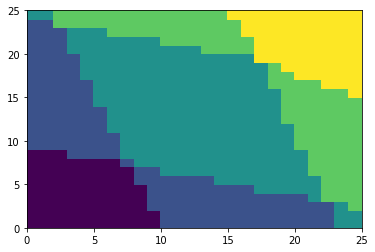

In [239]:
import sys
import time
sys.path.append("/Users/sandesh/repos/quantum-ml/nanowire_model/")

import potential_profile

N_v = 25
Vd1_vec = np.linspace(600e-3,800e-3,N_v)
Vd2_vec = np.linspace(600e-3,800e-3,N_v)
# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [def_gates + [[x,-0.2,0.1,1],[y,0.2,0.1,1]] for x in Vd1_vec for y in Vd2_vec]

st = time.time()
tf = ThomasFermi(physics) 
def wrapper(V_x):
    tf.physics['V_x'] = V_x
    try:
        config = tf.calc_stable_charge_config()
    #short circuit condition
    except KeyError as e: 
        config = (0)
    return config

charge_config = [wrapper(find_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)
plt.pcolor(np.array([np.sum(x) for x in charge_config]).reshape((N_v,N_v)))

In [248]:
# current calulation
N_v = 100
Vd1_vec = np.linspace(-250e-3,-450e-3,N_v)
Vd2_vec = np.linspace(-250e-3,-450e-3,N_v)
# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [def_gates + [[a,-0.7,0.2,1],[b,0.7,0.2,1]] for a in Vd1_vec for b in Vd2_vec]

st = time.time()
graph_model = (1,1)
def wrapper_curr(V_x):
    physics['V_x'] = V_x
    try:
        markov = Markov(graph_model,physics) 
        markov.generate_graph()
        curr = markov.calc_current()
        charge = markov.calc_charge_state()
        del markov
    except KeyError as e:
        curr = 0
        charge = [0]
    return  curr,charge

current = [wrapper_curr(find_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)



Time 298.1705949306488
